# Nowcasting American GDP Growth using a Neural Network

In this project, a Long Short-Term Memory (LSTM) model is trained to predict the growth in American GDP one subsequent quarter at a time. In general, the model appears to be doing a decent but far from perfect job of predicting growth. As a final step of the analysis, a simple AR(2) model is estimated to be used as a benchmark. The predictions by the AR model are indeed outperformed by those of the network, albeit with a very small margin. This implies that there is still room for improvements of the network used. A plan for the future is therefore to include more variables when training the network and see if this improves the model.

## Load required packages

In [406]:
%%capture
import pandas as pd
import os
from functools import reduce
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.ar_model as ar_model

from numpy.random import seed
seed(42)

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

## Import Data

The data used is retrieved from the [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/). The variables included in the analysis are:

* Real GDP - GDPC1
* Industrial Production Index - INDPRO
* Real Disposable Personal Income - DPIC96
* Unemployment Rate - UNRATE
* All Employees, Total Nonfarm - PAYEMS
* Personal Consumption Expenditures - PCEC
* Producer Price Index by Commodity: All Commodities - PPIACO
* Consumer Price Index for All Urban Consumers: All Items in U.S. City Average - CPIAUCSL
* Real imports of goods and services - IMPGSC1
* Real Exports of Goods and Services - EXPGSC1
* Change in Private Inventories - CBI
* Capacity Utilization: Manufacturing - CUMFNS

In [407]:
%%capture
cwd = os.getcwd() 
data_folder = cwd + r'\Desktop\neural\data_nowcast'

var_lst = ['GDPC1', 'INDPRO', 'DPIC96', 'UNRATE', 'PAYEMS', 'PCEC', 'PPIACO', 'CPIAUCSL', 'IMPGSC1', 'EXPGSC1', 'CBI', 'CUMFNS']

df_lst = []

def load_data(file):
    ''' Load data and store it in a list of dataframes '''
    df_in = pd.read_csv(data_folder + r'\{}.csv'.format(file))
    df_lst.append(df_in)

[load_data(file) for file in var_lst]

About half of the data series above are given on a monthly basis and the remaining on a quarterly basis. These are merged together below resulting in quarterly data. The first two quarters of 2020 are dropped to exclude the quite violent effects COVID-19 has had on the economy.

In [408]:
df = reduce(lambda left, right: pd.merge(left, right, on = 'DATE'), df_lst)

df.set_index('DATE', inplace = True)
df.dropna(inplace = True)

df = df.iloc[90:-2, :]

## Visualize the Data

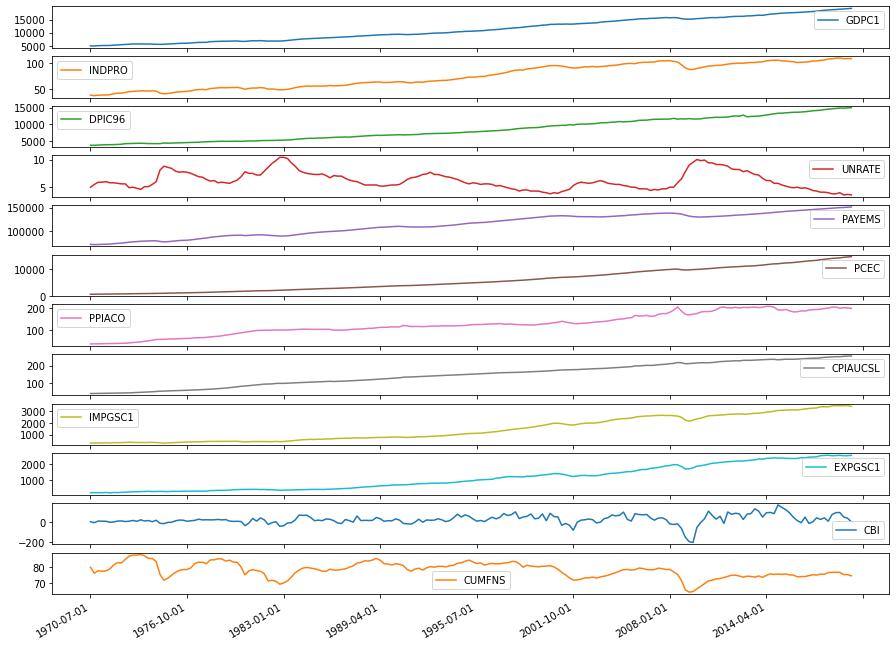

In [409]:
df.plot(subplots = True, figsize = (15, 12))
plt.xlabel('')
plt.show()

### Log Transform and First Difference


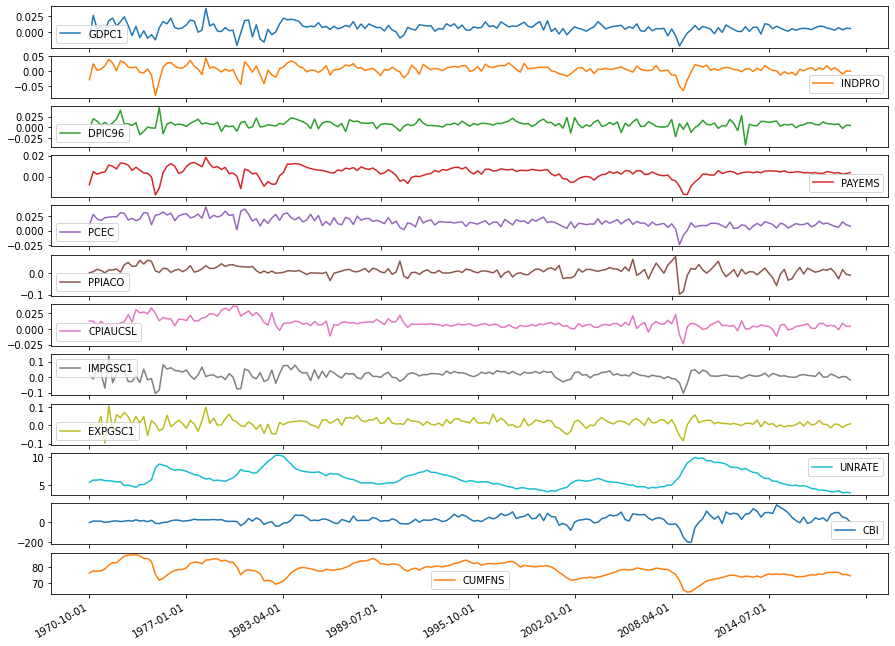

In [410]:
df_log  = np.log(df[['GDPC1', 'INDPRO', 'DPIC96', 'PAYEMS', 'PCEC', 'PPIACO', 'CPIAUCSL', 'IMPGSC1', 'EXPGSC1']])

df_diff = df_log.diff()

df_diff[['UNRATE', 'CBI', 'CUMFNS']] = df[['UNRATE', 'CBI', 'CUMFNS']]

df_diff = df_diff.iloc[1:,:]
df_diff.plot(subplots = True, figsize = (15, 12))

plt.xlabel('')
plt.show()

## Prepare Data for Network

### Scale Data 

The data is scaled to the [0,1] range using the ``` MinMaxScaler ``` from scikit-learn.

In [411]:
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(df_diff)

### Generate Lags of all Variables

In [412]:
# Convert the scaled data into a dataframe
scaled_df = pd.DataFrame(data_scaled)
scaled_df.columns = df.columns
scaled_df.set_index
scaled_df['index'] = scaled_df.index

# Generate a new dataframe only containing GDP
Y = scaled_df[['index', 'GDPC1']].iloc[1:]

# Add a suffix indicating a one period lag
scaled_df = scaled_df.add_suffix('(t-1)')

# Adjust the index of Y
Y['index'] = Y['index'] -1
Y = Y.add_suffix('(t)')

# Merging on the new index generates a dataframe with lagged values of all variables
reframed = scaled_df.merge(Y, how = 'inner', left_on= 'index(t-1)', right_on='index(t)')
reframed.drop(['index(t-1)', 'index(t)'], axis = 'columns', inplace= True)

reframed.head()

,GDPC1(t-1),INDPRO(t-1),DPIC96(t-1),UNRATE(t-1),PAYEMS(t-1),PCEC(t-1),PPIACO(t-1),CPIAUCSL(t-1),IMPGSC1(t-1),EXPGSC1(t-1),CBI(t-1),CUMFNS(t-1),GDPC1(t)
0,0.185672,0.425704,0.446768,0.271270,0.525325,0.569650,0.604632,0.500229,0.483717,0.279412,0.526853,0.504341,0.814067
1,0.814067,0.842913,0.704185,0.619894,0.801975,0.601045,0.601955,0.387715,0.518043,0.338235,0.569624,0.567555,0.456131
2,0.456131,0.672848,0.642602,0.550742,0.681387,0.662836,0.475454,0.737008,0.437305,0.338235,0.565992,0.554223,0.502955
3,0.502955,0.702113,0.535154,0.593251,0.639423,0.630958,0.598318,0.526975,0.712100,0.352941,0.564182,0.565098,0.405261
4,0.405261,0.791660,0.609286,0.611691,0.714097,0.569650,0.514715,0.146829,0.000000,0.323529,0.536570,0.616055,0.670647


### Generate Training and Testing Samples
The data is split into a training and a testing sample consisting of 85% and 15% of the data, respectively. The training sample stretches from the second quarter of 1948 to the second quarter of 2010 while the test sample stretches from the third quarter of 2010 to the last quarter of 2019. 

In [413]:
train_len = round(0.85 * len(df))
train     = reframed.iloc[:train_len, :]
test      = reframed.iloc[train_len:, :]

train_X = train.iloc[:, :-1] 
train_y = train.iloc[:, -1]
test_X  = test.iloc[:, :-1]
test_y  = test.iloc[:, -1]

train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))

## Analysis
### Design Network

In [414]:
# Parameters
n_lyrs   = 30
n_epochs = 100
b_size   = 50

# Specify model
model = Sequential()
model.add(LSTM(n_lyrs, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_lyrs))
model.add(Dense(1)) 

model.compile(loss='mae', optimizer='adam')

### Fit the model

In [415]:
history = model.fit(train_X, 
                    train_y, 
                    epochs = n_epochs, 
                    batch_size = b_size,
                    validation_split = 0.75,
                    verbose = 0, 
                    shuffle = False)

### Plot Model Training History 

The plot below shows the loss for the training and validation datasets during the training process of the model. As can be seen, the performance is similar for both the training and validation sets, indicating that we neither have too much over- nor underfitting.  

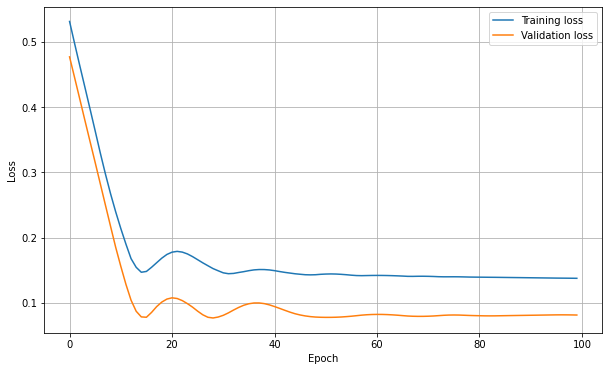

In [416]:
plt.figure(figsize = (10, 6))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

### Generate a Prediction and Calculate RMSE

In this step, predictions are made using the test sample and the model trained above. In addition to this, the RMSE of the predictions are calculated.

In [417]:
# Generate prediction using test data and model trained above 
yhat     = model.predict(test_X)
test_X   = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert the scaling for the predictions
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert the scaling for the actual data
test_y   = test_y.values.reshape((len(test_y), 1))
inv_y    = np.concatenate((test_y, test_X[:, 1:]), axis = 1)
inv_y    = scaler.inverse_transform(inv_y)
inv_y    = inv_y[:,0]

# Calculate the RMSE for the prediction 
rmse     = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: \n%.3f' % rmse)

Test RMSE: 
0.003


## Visualize Predicted vs Actual Growth

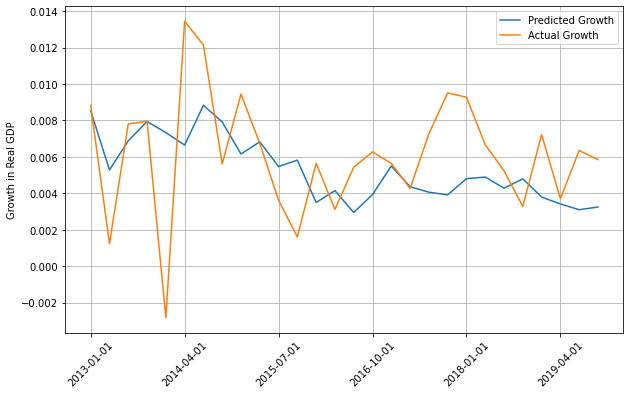

In [418]:
# Generate a dataframe with the predictions and actual values
y = np.concatenate((inv_yhat[:, np.newaxis], inv_y[:, np.newaxis]), axis = 1)
y_df = pd.DataFrame(y, columns= ['Predicted Growth', 'Actual Growth'])
y_df.index = df_log.index[-len(inv_yhat):]

y_df.plot(rot = 45, figsize = (10, 6))
plt.xlabel('')
plt.ylabel('Growth in Real GDP')
plt.grid()
plt.show()

The results in the figure above suggest that the predictions are far from perfect. In several cases the model does a fairly good job of predicting the changes in GDP. In other cases, however, the predictions deviate significantly from actual GDP growth.

### Convert Predicted Growth to GDP

Below the predicted GDP is calculated from the predicted growth rate and compared to the actual GDP.

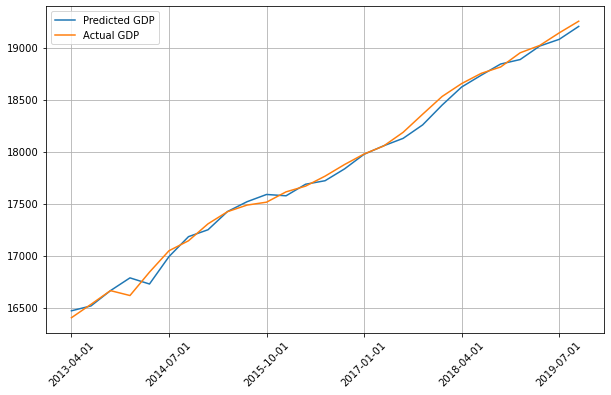

In [419]:
# Generate array with the logged GDP values
log_arr = df_log.iloc[-len(inv_yhat):, 0].values

# Add predictions and empty columns
log_arr = np.concatenate((log_arr[:, np.newaxis], y), axis = 1)
log_arr = np.concatenate((log_arr, np.zeros([log_arr.shape[0], 2])), axis = 1)

for i in range(0, log_arr.shape[0]-1):
    # Add the predicted changes to the logged GDP values
    log_arr[i+1, 4] = log_arr[i+1, 2] + log_arr[i, 0]
    log_arr[i+1, 3] = log_arr[i+1, 1] + log_arr[i, 0]

# Invert the log
out_arr = np.exp(log_arr)

# Generate a dataframe with the final predictions
out_df = pd.DataFrame(out_arr[:, 3:5], columns = ['Predicted GDP', 'Actual GDP'])
ix = df_log.index[-len(inv_yhat):]
out_df.index = df_log.index[-len(inv_yhat):]
out_df = out_df.iloc[1:, :]

out_df.plot(rot = 45, figsize = (10, 6))
plt.xlabel('')
plt.grid()
plt.show()

## Comparision with Autoregressive Model
### Check for Stationarity

In [420]:
adf = adfuller(df_diff['GDPC1'])
print('ADF Statistic: %.3f' % adf[0])
print('p-value: %.3f ' % adf[1])

ADF Statistic: -4.684
p-value: 0.000 


Given the small p-value we can reject the null hypothesis that there is a unit root in the GDP series and assume that the series is stationary.

### Select Lag Length Based on Partial Autocorrelation

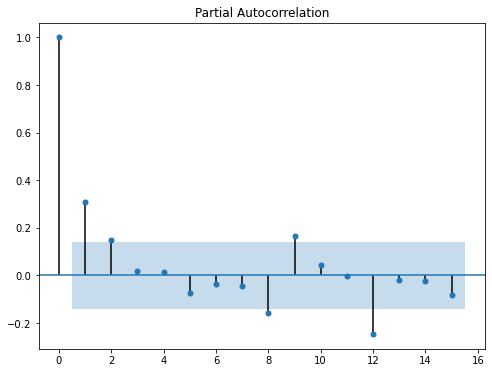

In [421]:
fig, ax = plt.subplots(figsize = (8, 6))

plot_pacf(df_diff['GDPC1'], ax = ax,  lags = 15)

plt.show()

Based on the plot above it appears a lag length of 2 would be appropriate for the autoregressive model.

### Estimate AR(2) Model

In [422]:
%%capture
# Divide the GDP series into a training and testing sample
gdp_train = df_diff['GDPC1'].iloc[0:-len(inv_yhat)+1]
gdp_test  = df_diff['GDPC1'].iloc[-len(inv_yhat)-2:]

# Fit an autoregressive model to the training sample
ar = ar_model.AR(gdp_train)
model_ar = ar.fit(maxlag = 2)

# Store the estimated parameters  
pars = model_ar.params

### Generate Predictions

In [423]:
%%capture
# Generating empty series for storing results
ar_pred = pd.Series()

for i in range(2, len(gdp_test.index)):
    # Iterate through the test data and make a prediction for each consecutive period using 
    # the estimated parameters of the AR model
     
    lags   = np.concatenate(([1], gdp_test.iloc[i-2:i].values))
    lag_df = pd.DataFrame(lags, index = pars.index)
    
    # Manually generate a prediction using the lagged values and the estimated coefficients
    lag_df['pars'] = pars
    lag_df['est']  = lag_df['pars']*lag_df[0]
    pred           = pd.Series(lag_df['est'].sum())
    
    # Store the estimated predictions
    ar_pred = ar_pred.append(pred, ignore_index = True)

ar_pred.index = y_df.index

### Plot All Predictions

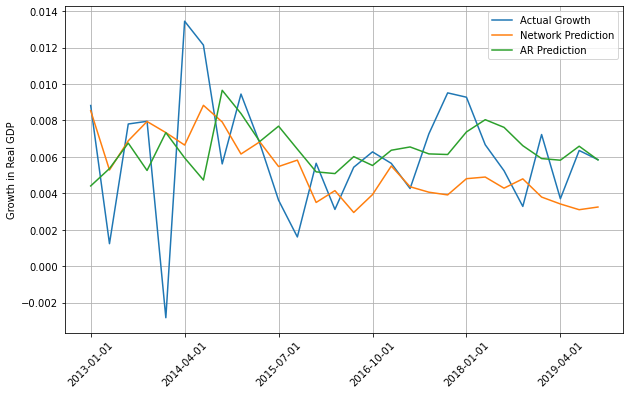

In [424]:
# Generate a dataframe with the predictions and actual values
y = np.concatenate((inv_y[:, np.newaxis], 
                    inv_yhat[:, np.newaxis], 
                    ar_pred.values[:, np.newaxis]), 
                   axis = 1)
y_df = pd.DataFrame(y, columns= ['Actual Growth', 'Network Prediction', 'AR Prediction'])
y_df.index = df_log.index[-len(inv_yhat):]

y_df.plot(rot = 45, figsize = (10, 6))
plt.xlabel('')
plt.ylabel('Growth in Real GDP')
plt.grid()
plt.show()

It's difficult to draw any conclusions about the performance of the different models based on the figure above. As a more objective measure the RMSE for the AR model is also calculated below.

In [425]:
rmse     = np.sqrt(mean_squared_error(inv_y, ar_pred.values))
print('RMSE: \n%.3f' % rmse)

RMSE: 
0.004


The RMSE for the AR(2) model turns out to be somewhat larget than that of the network, with a RMSE of 0.003. The difference however, is not very impressive and implies that there's indeed room for future improvements of the network.